In [44]:
'''Line up the peak (by offsetting the peak or just throw away data before the peak)
Labeling the lightcurve for different type of supernova
Interpolation that taken account in the non-uniform timestep? --DONE
Feed the output back as input to see anything reasonable --DONE
Throw away data without a rising peak (calculate the average nemerical slope before the maximum) --DONE
Truncate the no. of days --DONE
Try using relative physical date as input (don't need to interpolate for uniform step in this way?) --DONE
Smoothing the interpolation by taking average
Just use one telescope? --DONE
Try multiple band?
See see the output from the encoding part
Philips relation from the output --DONE
Dropout layer (much worse learning as predicted) --DONE
Training and predicting with lightcurve with large data gaps'''

"Line up the peak (by offsetting the peak or just throw away data before the peak)\nLabeling the lightcurve for different type of supernova\nInterpolation that taken account in the non-uniform timestep? --DONE\nFeed the output back as input to see anything reasonable --DONE\nThrow away data without a rising peak (calculate the average nemerical slope before the maximum) --DONE\nTruncate the no. of days --DONE\nTry using relative physical date as input (don't need to interpolate for uniform step in this way?) --DONE\nSmoothing the interpolation by taking average\nJust use one telescope? --DONE\nTry multiple band?\nSee see the output from the encoding part\nPhilips relation from the output --DONE\nDropout layer (much worse learning as predicted) --DONE\nTraining and predicting with lightcurve with large data gaps"

In [45]:
import os
import glob
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, splrep

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.optimizers import Adam

In [46]:
# Import the .json file

os.chdir(r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\typeIa_photometry")
filename = glob.glob('*.json')
np.random.shuffle(filename)
print(filename)

# Create a list for all .json, the 1st SN saved as json_data[0], the 2nd SN saved as json_data[1], etc.
json_data = []
for i in filename:
    with open(i, encoding="utf-8") as f:
        json_data.append(json.load(f))

['SN2008C.json', 'SN1994ae.json', 'SN2016dxj.json', 'SN2007if.json', 'SN2017fgc.json', 'SN2005ag.json', 'SN2018bac.json', 'SN1937C.json', 'SN2017erp.json', 'SN2004gs.json', 'SN2008hv.json', 'SN2005ki.json', 'SN2016fbo.json', 'SN2002fk.json', 'SN2006D.json', 'SN2009an.json', 'SN1994D.json', 'SN2007jg.json', 'SN2003du.json', 'SN2005hc.json', 'SN2007on.json', 'SN2018gv.json', 'SN2000cx.json', 'SN1989B.json', 'SN2005na.json', 'SN2012hr.json', 'SN2017drh.json', 'SN2005am.json', 'SN2004eo.json', 'SN2019kg.json', 'SN2015F.json', 'SN2011by.json', 'SN2008hs.json', 'SN2005cf.json', 'SN2006ax.json', 'SN2013aa.json', 'SN2005el.json', 'SN2000E.json', 'SN2013gy.json', 'SN1999ee.json', 'SN2007af.json', 'SN2011fe.json', 'SN1998bu.json', 'SN2006le.json', 'SN2016hvl.json', 'SN2012ht.json', 'SN1980N.json', 'SN2012fr.json', 'SN2017hbi.json', 'SN2007sr.json', 'SN1990N.json', 'SN2016dxv.json', 'SN2003cg.json', 'SN2012cg.json', 'SN2016coj.json', 'SN1972E.json', 'SN1981B.json', 'SN2013gh.json', 'SN2001el.json

In [47]:
# To obtain absolute magnitude and time in a particular band

Band = [] # Contain EM band chosen for analysis
Magnitude_Abs = [] # Contain absolute magnitude
Time = [] # Contain time (day)
Type = [] # Claimed type
Sample_Count = 0


for i in range(len(filename)): # Loop through all SN
    
    Source = []
    
    Band.append([]) # Create 2D list
    
    SN_name = filename[i].replace('.json', '')
    SN_name = SN_name.replace('_', ':')
    
    Type.append(json_data[i][SN_name]['claimedtype'][0]['value'])
    
    N = len(json_data[i][SN_name]['photometry']) # The no. of data point of photometry in each SN
    
    for j in range(N): # Loop through all photemetry datapoint in one SN
        # Avoid any data point without band data
        try:
            Band[i].append(json_data[i][SN_name]['photometry'][j]['band'])
        except:
            Band[i].append(0)
        
        # Fill the Magnitude_Abs and Time list if the data point is in B band
        if Band[i][j] == 'B':
            
            Source.append(json_data[i][SN_name]['photometry'][j]['source'])
            Source = list(set(Source))
            
    if len(Source) == 0:
        Source.append('0')
            
    
    for k in range(len(Source)):
        for j in range(N):
            if (Band[i][j] == 'B') & (json_data[i][SN_name]['photometry'][j]['source'] == Source[k]):
                Magnitude_App = float(json_data[i][SN_name]['photometry'][j]['magnitude']) # Obtain the apparent magnitude from photometry
                LumDist = float(json_data[i][SN_name]['lumdist'][0]['value']) # Obtain the luminosity distance
                z = float(json_data[i][SN_name]['redshift'][0]['value']) # Obtain the redshift, z
                
                Magnitude_Abs.append([])
                Time.append([])
                
                Magnitude_Abs[Sample_Count].append(Magnitude_App - 5*np.log10(LumDist*1e5) + 2.5*np.log10(1+z)) # Calculate the absolute magnitude and fill the Magnitude_Abs list
                Time[Sample_Count].append(float(json_data[i][SN_name]['photometry'][j]['time'])) # Fill the Time list
    
        Sample_Count += 1
    
    #print(Source)
print(Sample_Count)
print(len(filename))

198
60


The maximum lightcurve length is 117
[6, 7, 24, 26, 27, 28, 29, 30, 34, 52, 53, 56, 58, 59, 62, 66, 71, 78, 82, 86, 87, 105, 107, 108, 115, 116, 117, 119, 120, 122, 123, 130, 132, 133, 137, 144, 145, 147, 148, 152, 156, 159, 162, 163, 193, 194, 197]
No. of data is 47
25


<ipython-input-68-10be22e1112a>:23: RuntimeWarning: divide by zero encountered in double_scalars
  slope += (Magnitude_Abs[i][j+1] - Magnitude_Abs[i][j]) / (Time[i][j+1] - Time[i][j]) # Calculate the average slope between 1st and 4th data point to select out data with rising peak only


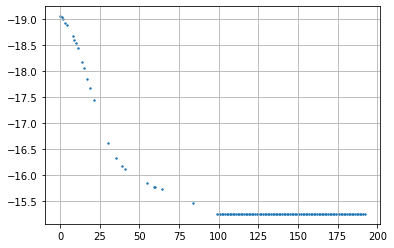

25


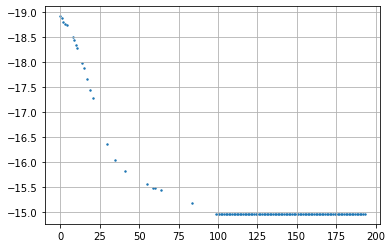

26


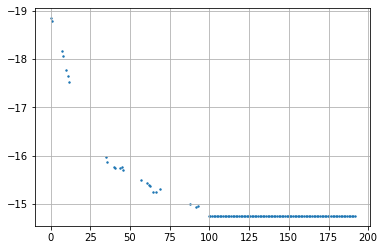

19


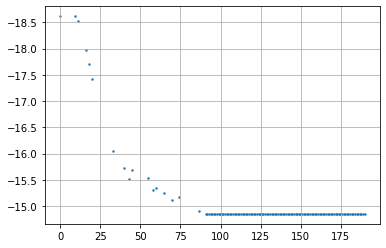

18


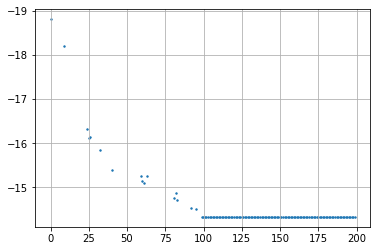

41


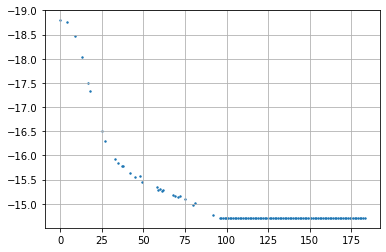

55


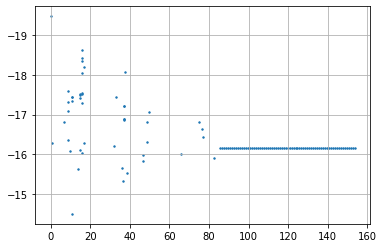

32


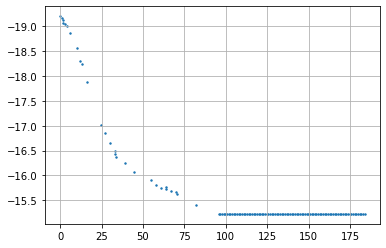

36


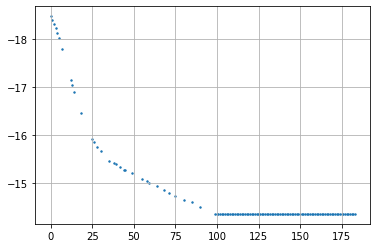

44


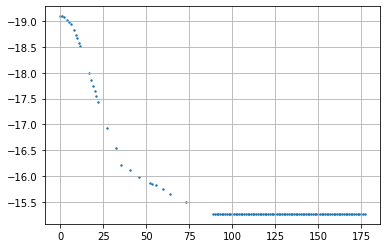

19


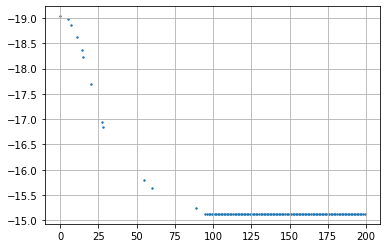

19


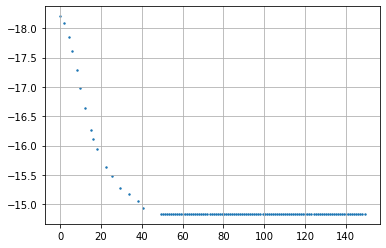

63


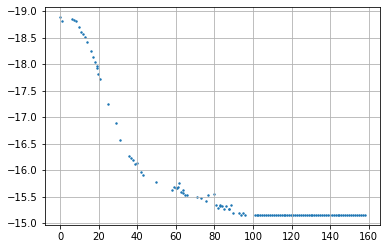

43


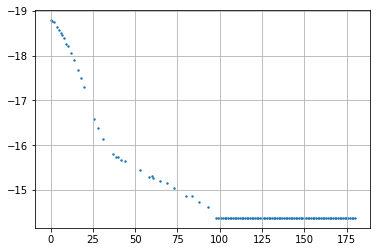

45


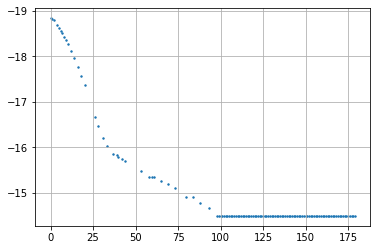

63


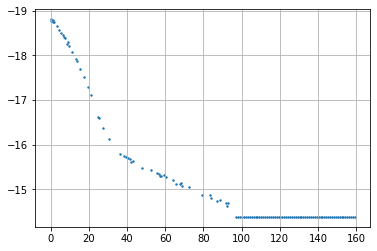

31


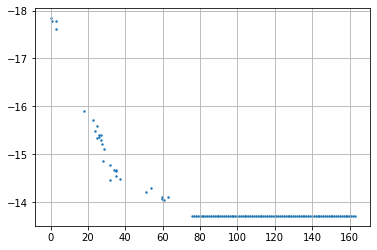

55


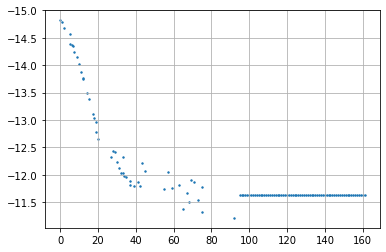

70


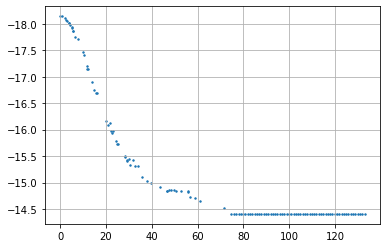

39


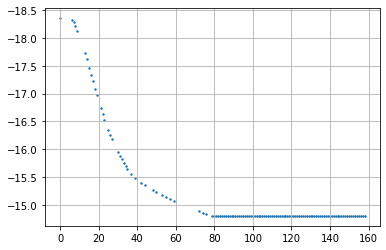

42


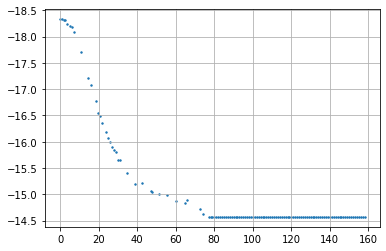

22


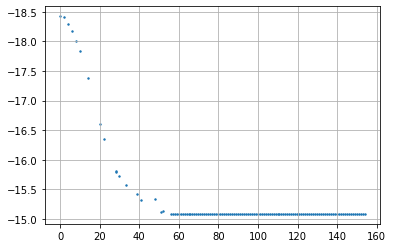

20


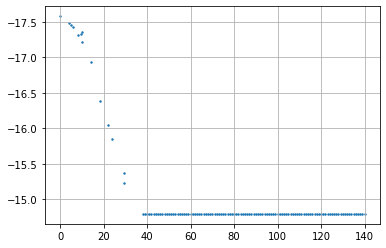

20


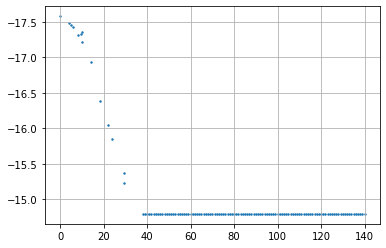

133


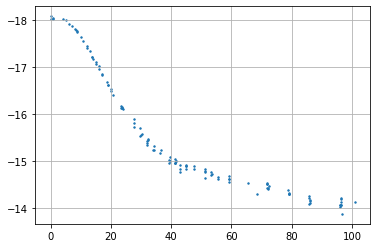

36


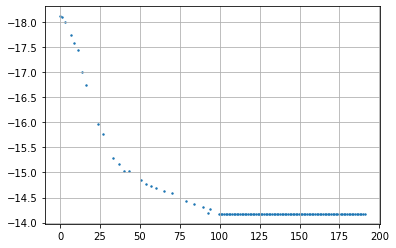

43


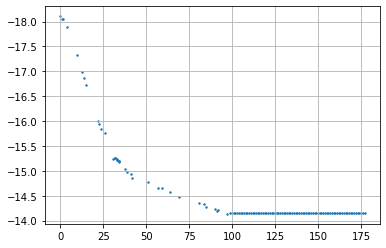

212


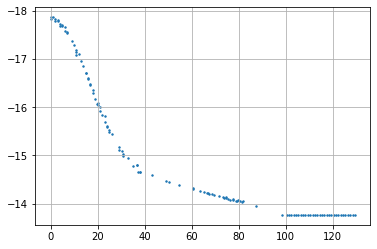

63


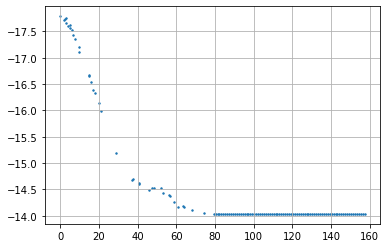

50


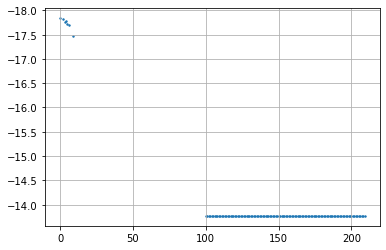

51


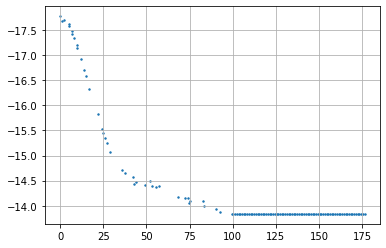

46


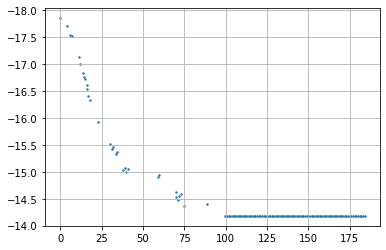

23


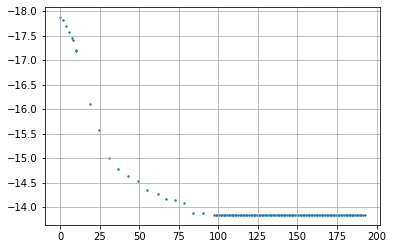

43


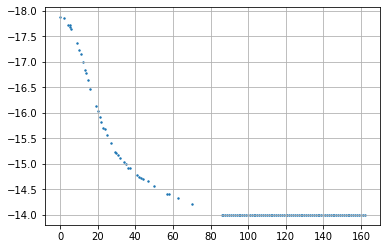

77


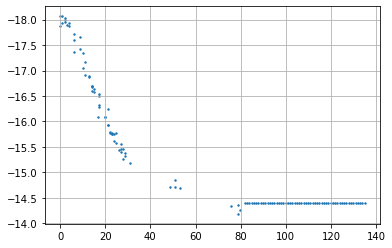

19


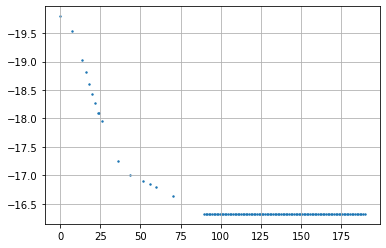

66


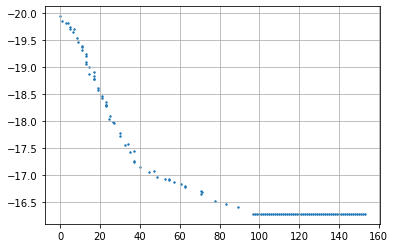

92


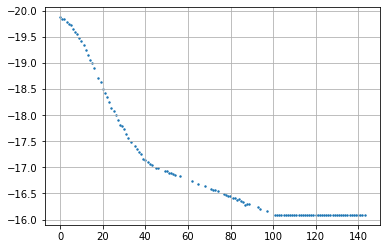

43


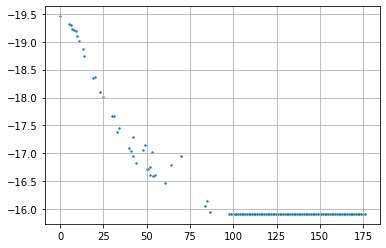

25


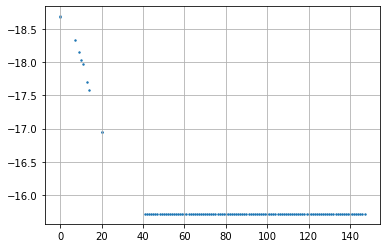

42


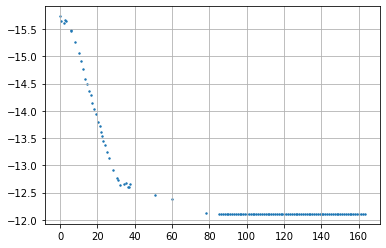

19


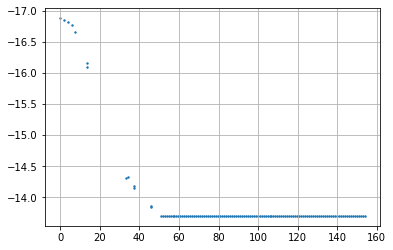

59


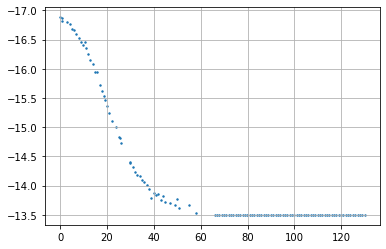

36


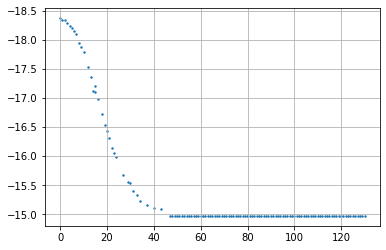

38


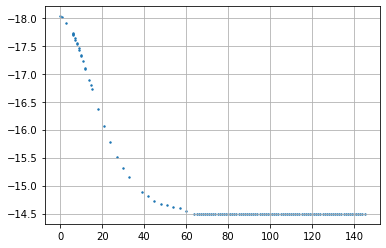

38


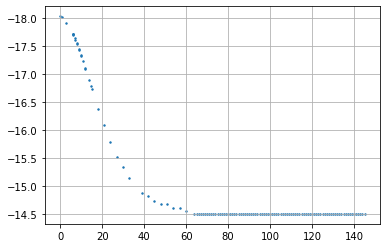

24


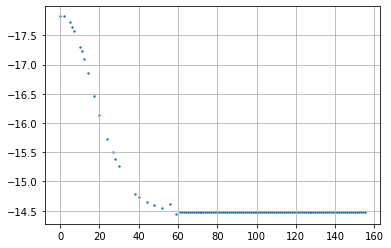

In [68]:
# Padding the data

data = []
lightcurve_length_max = 0
lightcurve_length = []
lightcurve_days = 100
lightcurve_succ = [] # Store the exact lightcurves that are filtered
Time_tail = []
Magnitude_Abs_tail = []
t = []
m = []

# Data selection
for i in range(Sample_Count):
    
    Time_tail.append([])
    Magnitude_Abs_tail.append([])
    
    if len(Time[i]) > 20: # Avoid lightcurve with too few data points
        
        slope = 0
        for j in range(3): # Maybe try to use polynomial fit and check if minimum exist?
            slope += (Magnitude_Abs[i][j+1] - Magnitude_Abs[i][j]) / (Time[i][j+1] - Time[i][j]) # Calculate the average slope between 1st and 4th data point to select out data with rising peak only
            
        if slope < 0:
            
            maximum = np.argmin(Magnitude_Abs[i])
            Time_tail[i] = Time[i][maximum:]
            Magnitude_Abs_tail[i] = Magnitude_Abs[i][maximum:]
            
            if (Time_tail[i][-1] - Time_tail[i][0]) > lightcurve_days: # Select lightcurves longer than 100 days
                
                for j in range(len(Time_tail[i])):
                    if (Time_tail[i][j] - Time_tail[i][0]) > lightcurve_days:
                        
                        lightcurve_length.append(j-1) # Store the no. of data point of each lightcurve just before 100 days
                        lightcurve_length_max = max([j, lightcurve_length_max]) # Obtain the maximum lightcurve length
                        lightcurve_succ.append(i)
                        break
        
print('The maximum lightcurve length is', lightcurve_length_max)
print(lightcurve_succ)

# Padding the lightcurve
k = 0

t_temp = []
m_temp = []

for i in range(len(lightcurve_succ)):
    
    t.append([])
    m.append([])
    t_temp.append([])
    m_temp.append([])
    
    for j in range(lightcurve_length_max - lightcurve_length[i]):
        t_temp[i].append(Time_tail[lightcurve_succ[i]][lightcurve_length[i]] - Time_tail[lightcurve_succ[i]][0] + j + 1) # Padding days, +1 day after each datapoint after 100 days
        m_temp[i].append(Magnitude_Abs_tail[lightcurve_succ[i]][lightcurve_length[i]]) # Padding magnitude with the magnitude just before 100 days
        #m_temp[i].append(-10)
        
    t_temp2 = np.array(Time_tail[lightcurve_succ[i]][0:lightcurve_length[i]])
    t_temp2 = t_temp2[:] - Time_tail[lightcurve_succ[i]][0] # Create a relative days
        
    t[i] = np.hstack((t_temp2, t_temp[i]))
    m[i] = np.hstack((Magnitude_Abs_tail[lightcurve_succ[i]][0:lightcurve_length[i]], m_temp[i]))
    data.append([t[i], m[i]])


print('No. of data is', len(data))
    
# Print out the padded lightcurve
for i in range(len(data)):
    print(len(Time_tail[lightcurve_succ[i]]))
    plt.gca().invert_yaxis()
    plt.grid()
    plt.scatter(data[i][0], data[i][1], s=2)
    plt.show()

In [49]:
# Spliting training set and testing set

split_portion = 0.8

data = np.array(data)
split = int(split_portion*len(data))
data_train = data[:split]
data_test = data[split:]
lightcurve_train = data_train.transpose((0, 2, 1)) #no. of sample (batch size), timesteps in RNN, no. of features
lightcurve_test = data_test.transpose((0, 2, 1))

print(lightcurve_train.shape)
print(lightcurve_test.shape)

#plt.scatter(lightcurve_train[4,:,0], lightcurve_train[4,:,1], s=2)

(37, 117, 2)
(10, 117, 2)


In [50]:
'''# Interpolating the data

data = []
lightcurve_length_max = 0
lightcurve_length = []
lightcurve_succ = []
lightcurve_days = 130


# To obtain individual lightcurve length (timesteps length) and the maximum lightcurve length
for i in range(len(filename)):
    
    if len(Time[i]) > 65: # Avoid lightcurve with too few data points
        if (Time[i][-1] - Time[i][0]) > lightcurve_days:
            for j in range(len(Time[i])):
                if (Time[i][j] - Time[i][0]) > lightcurve_days:
                    lightcurve_length.append(j)
                    lightcurve_length_max = max([j, lightcurve_length_max])
                    lightcurve_succ.append(1)
                    break
        else:
            lightcurve_succ.append(0)
    else:
        lightcurve_succ.append(0)

print(lightcurve_length_max)
print(len(filename))
print(len(lightcurve_succ))
print(lightcurve_succ)
print(len(lightcurve_length))
print(lightcurve_length)

j = 0

steps = 150

for i in range(len(filename)):
    
    if lightcurve_succ[i] == 1:
        ''''''t_temp = np.array(Time[i]) 
        t = t_temp[:lightcurve_length[j]+1] - t_temp[0]
        print('no. of data points is', len(t))''''''
        print('the claimed type is', Type[i])
        t = np.linspace(0, lightcurve_length[j]+1, lightcurve_length[j]+1)
        print(len(t))
        m = Magnitude_Abs[i][:lightcurve_length[j]+1]
        print(len(m))
        f = interp1d(t, m)
        ''''''tnew = np.linspace(0, lightcurve_days, steps)''''''
        tnew = np.linspace(0, lightcurve_length[j]+1, steps)
        mnew = f(tnew)
        
        fig = plt.figure(figsize=(16,10))
        plt.gca().invert_yaxis()
        plt.grid()
        plt.scatter(t, m, s=2)
        plt.scatter(tnew, mnew, s=2)
        plt.show()
        
        data.append(mnew)
        j += 1'''

"# Interpolating the data\n\ndata = []\nlightcurve_length_max = 0\nlightcurve_length = []\nlightcurve_succ = []\nlightcurve_days = 130\n\n\n# To obtain individual lightcurve length (timesteps length) and the maximum lightcurve length\nfor i in range(len(filename)):\n    \n    if len(Time[i]) > 65: # Avoid lightcurve with too few data points\n        if (Time[i][-1] - Time[i][0]) > lightcurve_days:\n            for j in range(len(Time[i])):\n                if (Time[i][j] - Time[i][0]) > lightcurve_days:\n                    lightcurve_length.append(j)\n                    lightcurve_length_max = max([j, lightcurve_length_max])\n                    lightcurve_succ.append(1)\n                    break\n        else:\n            lightcurve_succ.append(0)\n    else:\n        lightcurve_succ.append(0)\n\nprint(lightcurve_length_max)\nprint(len(filename))\nprint(len(lightcurve_succ))\nprint(lightcurve_succ)\nprint(len(lightcurve_length))\nprint(lightcurve_length)\n\nj = 0\n\nsteps = 150\n\n

In [51]:
'''# Spliting training set and testing set

split_portion = 0.8

data = np.array(data)
split = int(split_portion*len(data))
data_train = data[:split]
data_test = data[split:]
lightcurve_train = data_train.reshape(len(data_train), steps, 1) #no. of sample (batch size), timesteps in RNN, no. of features
lightcurve_test = data_test.reshape(len(data_test), steps, 1)

print(lightcurve_train.shape)
print(lightcurve_test.shape)'''

'# Spliting training set and testing set\n\nsplit_portion = 0.8\n\ndata = np.array(data)\nsplit = int(split_portion*len(data))\ndata_train = data[:split]\ndata_test = data[split:]\nlightcurve_train = data_train.reshape(len(data_train), steps, 1) #no. of sample (batch size), timesteps in RNN, no. of features\nlightcurve_test = data_test.reshape(len(data_test), steps, 1)\n\nprint(lightcurve_train.shape)\nprint(lightcurve_test.shape)'

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_20 (GRU)                 (None, 117, 125)          48375     
_________________________________________________________________
gru_21 (GRU)                 (None, 117, 35)           17010     
_________________________________________________________________
gru_22 (GRU)                 (None, 10)                1410      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 117, 10)           0         
_________________________________________________________________
gru_23 (GRU)                 (None, 117, 35)           4935      
_________________________________________________________________
gru_24 (GRU)                 (None, 117, 125)          60750     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 117, 2)           

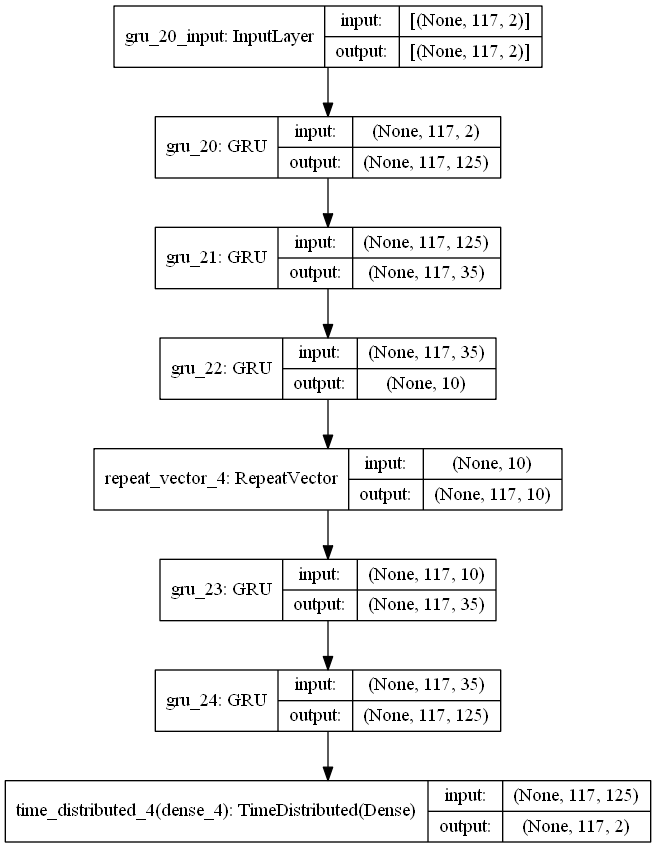

In [58]:
# define model
model = Sequential()
model.add(GRU(125, activation='tanh', input_shape=(lightcurve_length_max, 2), return_sequences=True))
model.add(GRU(35, activation='tanh', return_sequences=True))
model.add(GRU(10, activation='tanh', return_sequences=False))
model.add(RepeatVector(lightcurve_length_max))
model.add(GRU(35, activation='tanh', return_sequences=True))
model.add(GRU(125, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(2)))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.summary()
plot_model(model, show_shapes=True)

In [64]:
# Fit model
callbacks = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, restore_best_weights=True)
history = model.fit(lightcurve_train, lightcurve_train, validation_split = 0.2, epochs=2500, verbose=1, callbacks = [callbacks])

Epoch 1/2500
1/1 [==============================] - 0s 94ms/step - loss: 34.6887 - val_loss: 70.8048
Epoch 2/2500
1/1 [==============================] - 0s 71ms/step - loss: 34.6563 - val_loss: 70.5626
Epoch 3/2500
1/1 [==============================] - 0s 75ms/step - loss: 34.6475 - val_loss: 70.6834
Epoch 4/2500
1/1 [==============================] - 0s 74ms/step - loss: 34.6376 - val_loss: 70.4794
Epoch 5/2500
1/1 [==============================] - 0s 78ms/step - loss: 34.6461 - val_loss: 70.6500
Epoch 6/2500
1/1 [==============================] - 0s 73ms/step - loss: 34.5745 - val_loss: 70.2647
Epoch 7/2500
1/1 [==============================] - 0s 68ms/step - loss: 34.5153 - val_loss: 70.6908
Epoch 8/2500
1/1 [==============================] - 0s 76ms/step - loss: 34.4602 - val_loss: 70.0982
Epoch 9/2500
1/1 [==============================] - 0s 74ms/step - loss: 34.4062 - val_loss: 70.6593
Epoch 10/2500
1/1 [==============================] - 0s 72ms/step - loss: 34.3514 - val_los

1/1 [==============================] - 0s 72ms/step - loss: 31.0747 - val_loss: 65.0884
Epoch 82/2500
1/1 [==============================] - 0s 67ms/step - loss: 31.0158 - val_loss: 64.9164
Epoch 83/2500
1/1 [==============================] - 0s 65ms/step - loss: 30.9762 - val_loss: 64.8998
Epoch 84/2500
1/1 [==============================] - 0s 70ms/step - loss: 30.9427 - val_loss: 64.8329
Epoch 85/2500
1/1 [==============================] - 0s 64ms/step - loss: 30.8984 - val_loss: 64.7912
Epoch 86/2500
1/1 [==============================] - 0s 75ms/step - loss: 30.8402 - val_loss: 64.6594
Epoch 87/2500
1/1 [==============================] - 0s 69ms/step - loss: 30.7968 - val_loss: 64.6810
Epoch 88/2500
1/1 [==============================] - 0s 72ms/step - loss: 30.7532 - val_loss: 64.6075
Epoch 89/2500
1/1 [==============================] - 0s 70ms/step - loss: 30.7096 - val_loss: 64.5059
Epoch 90/2500
1/1 [==============================] - 0s 68ms/step - loss: 30.6757 - val_loss: 64

Epoch 161/2500
1/1 [==============================] - 0s 73ms/step - loss: 27.9329 - val_loss: 60.1067
Epoch 162/2500
1/1 [==============================] - 0s 72ms/step - loss: 27.8904 - val_loss: 59.9448
Epoch 163/2500
1/1 [==============================] - 0s 60ms/step - loss: 27.8473 - val_loss: 59.9789
Epoch 164/2500
1/1 [==============================] - 0s 64ms/step - loss: 27.8099 - val_loss: 59.8412
Epoch 165/2500
1/1 [==============================] - 0s 70ms/step - loss: 27.7863 - val_loss: 59.8736
Epoch 166/2500
1/1 [==============================] - 0s 65ms/step - loss: 27.7411 - val_loss: 59.7260
Epoch 167/2500
1/1 [==============================] - 0s 73ms/step - loss: 27.7191 - val_loss: 59.8026
Epoch 168/2500
1/1 [==============================] - 0s 72ms/step - loss: 27.6834 - val_loss: 59.6117
Epoch 169/2500
1/1 [==============================] - 0s 64ms/step - loss: 27.6682 - val_loss: 59.7584
Epoch 170/2500
1/1 [==============================] - 0s 69ms/step - loss

1/1 [==============================] - 0s 70ms/step - loss: 25.1928 - val_loss: 55.6841
Epoch 241/2500
1/1 [==============================] - 0s 67ms/step - loss: 25.1713 - val_loss: 55.5313
Epoch 242/2500
1/1 [==============================] - 0s 66ms/step - loss: 25.1365 - val_loss: 55.5517
Epoch 243/2500
1/1 [==============================] - 0s 62ms/step - loss: 25.1071 - val_loss: 55.4534
Epoch 244/2500
1/1 [==============================] - 0s 60ms/step - loss: 25.0693 - val_loss: 55.4265
Epoch 245/2500
1/1 [==============================] - 0s 60ms/step - loss: 25.0313 - val_loss: 55.3563
Epoch 246/2500
1/1 [==============================] - 0s 65ms/step - loss: 24.9959 - val_loss: 55.3386
Epoch 247/2500
1/1 [==============================] - 0s 69ms/step - loss: 24.9701 - val_loss: 55.2317
Epoch 248/2500
1/1 [==============================] - 0s 70ms/step - loss: 24.9212 - val_loss: 55.2246
Epoch 249/2500
1/1 [==============================] - 0s 71ms/step - loss: 24.9057 - val

1/1 [==============================] - 0s 70ms/step - loss: 22.7851 - val_loss: 51.6975
Epoch 320/2500
1/1 [==============================] - 0s 73ms/step - loss: 22.7540 - val_loss: 51.6161
Epoch 321/2500
1/1 [==============================] - 0s 58ms/step - loss: 22.7370 - val_loss: 51.6530
Epoch 322/2500
1/1 [==============================] - 0s 61ms/step - loss: 22.7109 - val_loss: 51.4802
Epoch 323/2500
1/1 [==============================] - 0s 70ms/step - loss: 22.6728 - val_loss: 51.4811
Epoch 324/2500
1/1 [==============================] - 0s 68ms/step - loss: 22.6303 - val_loss: 51.3799
Epoch 325/2500
1/1 [==============================] - 0s 68ms/step - loss: 22.6052 - val_loss: 51.3440
Epoch 326/2500
1/1 [==============================] - 0s 58ms/step - loss: 22.5745 - val_loss: 51.3378
Epoch 327/2500
1/1 [==============================] - 0s 59ms/step - loss: 22.5483 - val_loss: 51.2469
Epoch 328/2500
1/1 [==============================] - 0s 64ms/step - loss: 22.5193 - val

1/1 [==============================] - 0s 69ms/step - loss: 20.6321 - val_loss: 48.1526
Epoch 399/2500
1/1 [==============================] - 0s 72ms/step - loss: 20.6271 - val_loss: 48.1015
Epoch 400/2500
1/1 [==============================] - 0s 69ms/step - loss: 20.6193 - val_loss: 48.0558
Epoch 401/2500
1/1 [==============================] - 0s 71ms/step - loss: 20.5975 - val_loss: 48.1017
Epoch 402/2500
1/1 [==============================] - 0s 70ms/step - loss: 20.5774 - val_loss: 48.0020
Epoch 403/2500
1/1 [==============================] - 0s 72ms/step - loss: 20.5609 - val_loss: 48.1610
Epoch 404/2500
1/1 [==============================] - 0s 70ms/step - loss: 20.5443 - val_loss: 48.0134
Epoch 405/2500
1/1 [==============================] - 0s 68ms/step - loss: 20.5197 - val_loss: 48.0482
Epoch 406/2500
1/1 [==============================] - 0s 67ms/step - loss: 20.4828 - val_loss: 47.9103
Epoch 407/2500
1/1 [==============================] - 0s 68ms/step - loss: 20.4591 - val

1/1 [==============================] - 0s 70ms/step - loss: 18.9129 - val_loss: 45.5220
Epoch 478/2500
1/1 [==============================] - 0s 69ms/step - loss: 18.9116 - val_loss: 45.1849
Epoch 479/2500
1/1 [==============================] - 0s 71ms/step - loss: 18.8564 - val_loss: 45.0636
Epoch 480/2500
1/1 [==============================] - 0s 67ms/step - loss: 18.7571 - val_loss: 44.9589
Epoch 481/2500
1/1 [==============================] - 0s 68ms/step - loss: 18.7138 - val_loss: 44.7769
Epoch 482/2500
1/1 [==============================] - 0s 70ms/step - loss: 18.7249 - val_loss: 45.1352
Epoch 483/2500
1/1 [==============================] - 0s 69ms/step - loss: 18.7620 - val_loss: 44.8061
Epoch 484/2500
1/1 [==============================] - 0s 65ms/step - loss: 18.7213 - val_loss: 44.9157
Epoch 485/2500
1/1 [==============================] - 0s 67ms/step - loss: 18.6020 - val_loss: 44.5885
Epoch 486/2500
1/1 [==============================] - 0s 70ms/step - loss: 18.5024 - val

1/1 [==============================] - 0s 69ms/step - loss: 17.2463 - val_loss: 42.6028
Epoch 557/2500
1/1 [==============================] - 0s 69ms/step - loss: 17.1383 - val_loss: 42.3838
Epoch 558/2500
1/1 [==============================] - 0s 74ms/step - loss: 17.0677 - val_loss: 42.4592
Epoch 559/2500
1/1 [==============================] - 0s 70ms/step - loss: 17.0121 - val_loss: 42.2543
Epoch 560/2500
1/1 [==============================] - 0s 70ms/step - loss: 16.9736 - val_loss: 42.3141
Epoch 561/2500
1/1 [==============================] - 0s 60ms/step - loss: 16.9277 - val_loss: 42.1318
Epoch 562/2500
1/1 [==============================] - 0s 67ms/step - loss: 16.8859 - val_loss: 42.0663
Epoch 563/2500
1/1 [==============================] - 0s 69ms/step - loss: 16.8336 - val_loss: 41.9630
Epoch 564/2500
1/1 [==============================] - 0s 60ms/step - loss: 16.8106 - val_loss: 41.8769
Epoch 565/2500
1/1 [==============================] - 0s 72ms/step - loss: 16.7960 - val

1/1 [==============================] - 0s 60ms/step - loss: 15.5444 - val_loss: 39.8418
Epoch 636/2500
1/1 [==============================] - 0s 60ms/step - loss: 15.4722 - val_loss: 39.7523
Epoch 637/2500
1/1 [==============================] - 0s 62ms/step - loss: 15.4409 - val_loss: 39.8085
Epoch 638/2500
1/1 [==============================] - 0s 67ms/step - loss: 15.4456 - val_loss: 39.5654
Epoch 639/2500
1/1 [==============================] - 0s 69ms/step - loss: 15.4358 - val_loss: 39.6042
Epoch 640/2500
1/1 [==============================] - 0s 70ms/step - loss: 15.3864 - val_loss: 39.4425
Epoch 641/2500
1/1 [==============================] - 0s 72ms/step - loss: 15.3355 - val_loss: 39.4704
Epoch 642/2500
1/1 [==============================] - 0s 69ms/step - loss: 15.2999 - val_loss: 39.5161
Epoch 643/2500
1/1 [==============================] - 0s 63ms/step - loss: 15.2992 - val_loss: 39.4806
Epoch 644/2500
1/1 [==============================] - 0s 65ms/step - loss: 15.2935 - val

1/1 [==============================] - 0s 71ms/step - loss: 14.0489 - val_loss: 37.4564
Epoch 715/2500
1/1 [==============================] - 0s 69ms/step - loss: 14.0376 - val_loss: 37.4820
Epoch 716/2500
1/1 [==============================] - 0s 70ms/step - loss: 14.0309 - val_loss: 37.4210
Epoch 717/2500
1/1 [==============================] - 0s 63ms/step - loss: 14.0173 - val_loss: 37.4980
Epoch 718/2500
1/1 [==============================] - 0s 61ms/step - loss: 14.0123 - val_loss: 37.4276
Epoch 719/2500
1/1 [==============================] - 0s 60ms/step - loss: 14.0090 - val_loss: 37.5065
Epoch 720/2500
1/1 [==============================] - 0s 61ms/step - loss: 14.0158 - val_loss: 37.4240
Epoch 721/2500
1/1 [==============================] - 0s 63ms/step - loss: 14.0245 - val_loss: 37.4954
Epoch 722/2500
1/1 [==============================] - 0s 62ms/step - loss: 14.0293 - val_loss: 37.4183
Epoch 723/2500
1/1 [==============================] - 0s 63ms/step - loss: 14.0329 - val

1/1 [==============================] - 0s 69ms/step - loss: 12.8410 - val_loss: 35.5209
Epoch 794/2500
1/1 [==============================] - 0s 66ms/step - loss: 12.8443 - val_loss: 35.4606
Epoch 795/2500
1/1 [==============================] - 0s 65ms/step - loss: 12.8554 - val_loss: 35.5253
Epoch 796/2500
1/1 [==============================] - 0s 68ms/step - loss: 12.8648 - val_loss: 35.4673
Epoch 797/2500
1/1 [==============================] - 0s 69ms/step - loss: 12.8874 - val_loss: 35.6353
Epoch 798/2500
1/1 [==============================] - 0s 69ms/step - loss: 12.9273 - val_loss: 35.6544
Epoch 799/2500
1/1 [==============================] - 0s 64ms/step - loss: 13.0394 - val_loss: 35.9996
Epoch 800/2500
1/1 [==============================] - 0s 63ms/step - loss: 13.1870 - val_loss: 36.1607
Epoch 801/2500
1/1 [==============================] - 0s 61ms/step - loss: 13.4930 - val_loss: 36.7420
Epoch 802/2500
1/1 [==============================] - 0s 69ms/step - loss: 13.8147 - val

1/1 [==============================] - 0s 69ms/step - loss: 11.6890 - val_loss: 33.5765
Epoch 873/2500
1/1 [==============================] - 0s 67ms/step - loss: 11.6864 - val_loss: 33.5724
Epoch 874/2500
1/1 [==============================] - 0s 68ms/step - loss: 11.6887 - val_loss: 33.5924
Epoch 875/2500
1/1 [==============================] - 0s 67ms/step - loss: 11.6999 - val_loss: 33.5939
Epoch 876/2500
1/1 [==============================] - 0s 69ms/step - loss: 11.7132 - val_loss: 33.6063
Epoch 877/2500
1/1 [==============================] - 0s 61ms/step - loss: 11.7306 - val_loss: 33.6025
Epoch 878/2500
1/1 [==============================] - 0s 70ms/step - loss: 11.7495 - val_loss: 33.6061
Epoch 879/2500
1/1 [==============================] - 0s 70ms/step - loss: 11.7811 - val_loss: 33.6260
Epoch 880/2500
1/1 [==============================] - 0s 69ms/step - loss: 11.8253 - val_loss: 33.6636
Epoch 881/2500
1/1 [==============================] - 0s 70ms/step - loss: 11.8608 - val

1/1 [==============================] - 0s 69ms/step - loss: 10.7063 - val_loss: 31.6762
Epoch 952/2500
1/1 [==============================] - 0s 65ms/step - loss: 10.6845 - val_loss: 31.6990
Epoch 953/2500
1/1 [==============================] - 0s 67ms/step - loss: 10.6732 - val_loss: 31.6804
Epoch 954/2500
1/1 [==============================] - 0s 68ms/step - loss: 10.6715 - val_loss: 31.7733
Epoch 955/2500
1/1 [==============================] - 0s 75ms/step - loss: 10.6858 - val_loss: 31.7003
Epoch 956/2500
1/1 [==============================] - 0s 72ms/step - loss: 10.6812 - val_loss: 31.7045
Epoch 957/2500
1/1 [==============================] - 0s 71ms/step - loss: 10.6651 - val_loss: 31.6318
Epoch 958/2500
1/1 [==============================] - 0s 70ms/step - loss: 10.6356 - val_loss: 31.6244
Epoch 959/2500
1/1 [==============================] - 0s 70ms/step - loss: 10.5990 - val_loss: 31.6127
Epoch 960/2500
1/1 [==============================] - 0s 75ms/step - loss: 10.5711 - val

1/1 [==============================] - 0s 69ms/step - loss: 9.7893 - val_loss: 30.0596
Epoch 1031/2500
1/1 [==============================] - 0s 70ms/step - loss: 9.7889 - val_loss: 30.0987
Epoch 1032/2500
1/1 [==============================] - 0s 72ms/step - loss: 9.7736 - val_loss: 30.0780
Epoch 1033/2500
1/1 [==============================] - 0s 69ms/step - loss: 9.7537 - val_loss: 30.0804
Epoch 1034/2500
1/1 [==============================] - 0s 61ms/step - loss: 9.7480 - val_loss: 30.0830
Epoch 1035/2500
1/1 [==============================] - 0s 66ms/step - loss: 9.7415 - val_loss: 30.0227
Epoch 1036/2500
1/1 [==============================] - 0s 65ms/step - loss: 9.7292 - val_loss: 29.9969
Epoch 1037/2500
1/1 [==============================] - 0s 65ms/step - loss: 9.7198 - val_loss: 30.0378
Epoch 1038/2500
1/1 [==============================] - 0s 73ms/step - loss: 9.7239 - val_loss: 29.9867
Epoch 1039/2500
1/1 [==============================] - 0s 68ms/step - loss: 9.7270 - val_

1/1 [==============================] - 0s 71ms/step - loss: 8.9645 - val_loss: 28.7548
Epoch 1110/2500
1/1 [==============================] - 0s 68ms/step - loss: 8.9535 - val_loss: 28.7553
Epoch 1111/2500
1/1 [==============================] - 0s 67ms/step - loss: 8.9473 - val_loss: 28.7750
Epoch 1112/2500
1/1 [==============================] - 0s 68ms/step - loss: 8.9430 - val_loss: 28.7630
Epoch 1113/2500
1/1 [==============================] - 0s 72ms/step - loss: 8.9396 - val_loss: 28.7746
Epoch 1114/2500
1/1 [==============================] - 0s 71ms/step - loss: 8.9344 - val_loss: 28.7013
Epoch 1115/2500
1/1 [==============================] - 0s 71ms/step - loss: 8.9387 - val_loss: 28.7643
Epoch 1116/2500
1/1 [==============================] - 0s 64ms/step - loss: 8.9594 - val_loss: 28.6904
Epoch 1117/2500
1/1 [==============================] - 0s 68ms/step - loss: 8.9952 - val_loss: 28.8775
Epoch 1118/2500
1/1 [==============================] - 0s 59ms/step - loss: 9.0692 - val_

1/1 [==============================] - 0s 69ms/step - loss: 8.2685 - val_loss: 27.4316
Epoch 1189/2500
1/1 [==============================] - 0s 67ms/step - loss: 8.2642 - val_loss: 27.4003
Epoch 1190/2500
1/1 [==============================] - 0s 68ms/step - loss: 8.2543 - val_loss: 27.3933
Epoch 1191/2500
1/1 [==============================] - 0s 60ms/step - loss: 8.2416 - val_loss: 27.3940
Epoch 1192/2500
1/1 [==============================] - 0s 66ms/step - loss: 8.2286 - val_loss: 27.3682
Epoch 1193/2500
1/1 [==============================] - 0s 71ms/step - loss: 8.2170 - val_loss: 27.3640
Epoch 1194/2500
1/1 [==============================] - 0s 65ms/step - loss: 8.2060 - val_loss: 27.3183
Epoch 1195/2500
1/1 [==============================] - 0s 67ms/step - loss: 8.1974 - val_loss: 27.3354
Epoch 1196/2500
1/1 [==============================] - 0s 69ms/step - loss: 8.1905 - val_loss: 27.3074
Epoch 1197/2500
1/1 [==============================] - 0s 70ms/step - loss: 8.1865 - val_

1/1 [==============================] - 0s 69ms/step - loss: 7.7206 - val_loss: 25.9490
Epoch 1268/2500
1/1 [==============================] - 0s 69ms/step - loss: 7.6364 - val_loss: 25.8523
Epoch 1269/2500
1/1 [==============================] - 0s 67ms/step - loss: 7.6691 - val_loss: 25.9806
Epoch 1270/2500
1/1 [==============================] - 0s 67ms/step - loss: 7.6834 - val_loss: 25.9548
Epoch 1271/2500
1/1 [==============================] - 0s 65ms/step - loss: 7.6246 - val_loss: 26.1449
Epoch 1272/2500
1/1 [==============================] - 0s 70ms/step - loss: 7.6488 - val_loss: 26.1620
Epoch 1273/2500
1/1 [==============================] - 0s 70ms/step - loss: 7.6573 - val_loss: 26.0363
Epoch 1274/2500
1/1 [==============================] - 0s 73ms/step - loss: 7.5976 - val_loss: 25.8966
Epoch 1275/2500
1/1 [==============================] - 0s 68ms/step - loss: 7.6078 - val_loss: 26.0296
Epoch 1276/2500
1/1 [==============================] - 0s 65ms/step - loss: 7.6176 - val_

1/1 [==============================] - 0s 57ms/step - loss: 7.1162 - val_loss: 25.2313
Epoch 1347/2500
1/1 [==============================] - 0s 62ms/step - loss: 7.0801 - val_loss: 25.2079
Epoch 1348/2500
1/1 [==============================] - 0s 61ms/step - loss: 7.0572 - val_loss: 25.2067
Epoch 1349/2500
1/1 [==============================] - 0s 62ms/step - loss: 7.0442 - val_loss: 25.1994
Epoch 1350/2500
1/1 [==============================] - 0s 70ms/step - loss: 7.0367 - val_loss: 25.1841
Epoch 1351/2500
1/1 [==============================] - 0s 68ms/step - loss: 7.0292 - val_loss: 25.1727
Epoch 1352/2500
1/1 [==============================] - 0s 69ms/step - loss: 7.0279 - val_loss: 25.1580
Epoch 1353/2500
1/1 [==============================] - 0s 69ms/step - loss: 7.0242 - val_loss: 25.1601
Epoch 1354/2500
1/1 [==============================] - 0s 69ms/step - loss: 7.0251 - val_loss: 25.1470
Epoch 1355/2500
1/1 [==============================] - 0s 66ms/step - loss: 7.0245 - val_

1/1 [==============================] - 0s 75ms/step - loss: 6.5623 - val_loss: 24.2260
Epoch 1426/2500
1/1 [==============================] - 0s 71ms/step - loss: 6.5734 - val_loss: 24.1381
Epoch 1427/2500
1/1 [==============================] - 0s 72ms/step - loss: 6.6027 - val_loss: 24.3851
Epoch 1428/2500
1/1 [==============================] - 0s 70ms/step - loss: 6.6291 - val_loss: 24.1926
Epoch 1429/2500
1/1 [==============================] - 0s 71ms/step - loss: 6.6063 - val_loss: 24.3290
Epoch 1430/2500
1/1 [==============================] - 0s 67ms/step - loss: 6.5679 - val_loss: 24.1419
Epoch 1431/2500
1/1 [==============================] - 0s 59ms/step - loss: 6.5346 - val_loss: 24.1368
Epoch 1432/2500
1/1 [==============================] - 0s 64ms/step - loss: 6.5240 - val_loss: 24.1660
Epoch 1433/2500
1/1 [==============================] - 0s 66ms/step - loss: 6.5357 - val_loss: 24.1393
Epoch 1434/2500
1/1 [==============================] - 0s 66ms/step - loss: 6.5459 - val_

1/1 [==============================] - 0s 66ms/step - loss: 6.2606 - val_loss: 23.5138
Epoch 1505/2500
1/1 [==============================] - 0s 73ms/step - loss: 6.2556 - val_loss: 23.5443
Epoch 1506/2500
1/1 [==============================] - 0s 71ms/step - loss: 6.1886 - val_loss: 23.4017
Epoch 1507/2500
1/1 [==============================] - 0s 71ms/step - loss: 6.1007 - val_loss: 23.4239
Epoch 1508/2500
1/1 [==============================] - 0s 63ms/step - loss: 6.1214 - val_loss: 23.5933
Epoch 1509/2500
1/1 [==============================] - 0s 63ms/step - loss: 6.1704 - val_loss: 23.5048
Epoch 1510/2500
1/1 [==============================] - 0s 69ms/step - loss: 6.1424 - val_loss: 23.3558
Epoch 1511/2500
1/1 [==============================] - 0s 69ms/step - loss: 6.1416 - val_loss: 23.4988
Epoch 1512/2500
1/1 [==============================] - 0s 67ms/step - loss: 6.2027 - val_loss: 23.3023
Epoch 1513/2500
1/1 [==============================] - 0s 69ms/step - loss: 6.2349 - val_

1/1 [==============================] - 0s 72ms/step - loss: 5.8094 - val_loss: 22.7024
Epoch 1584/2500
1/1 [==============================] - 0s 69ms/step - loss: 5.7700 - val_loss: 22.8626
Epoch 1585/2500
1/1 [==============================] - 0s 69ms/step - loss: 5.7310 - val_loss: 22.6801
Epoch 1586/2500
1/1 [==============================] - 0s 70ms/step - loss: 5.6997 - val_loss: 22.6734
Epoch 1587/2500
1/1 [==============================] - 0s 72ms/step - loss: 5.6932 - val_loss: 22.7264
Epoch 1588/2500
1/1 [==============================] - 0s 67ms/step - loss: 5.7033 - val_loss: 22.5820
Epoch 1589/2500
1/1 [==============================] - 0s 68ms/step - loss: 5.7159 - val_loss: 22.8022
Epoch 1590/2500
1/1 [==============================] - 0s 71ms/step - loss: 5.7184 - val_loss: 22.5813
Epoch 1591/2500
1/1 [==============================] - 0s 68ms/step - loss: 5.7005 - val_loss: 22.7091
Epoch 1592/2500
1/1 [==============================] - 0s 69ms/step - loss: 5.6757 - val_

1/1 [==============================] - 0s 64ms/step - loss: 5.4014 - val_loss: 21.9839
Epoch 1663/2500
1/1 [==============================] - 0s 60ms/step - loss: 5.3912 - val_loss: 22.3857
Epoch 1664/2500
1/1 [==============================] - 0s 62ms/step - loss: 5.5724 - val_loss: 21.9691
Epoch 1665/2500
1/1 [==============================] - 0s 61ms/step - loss: 5.7077 - val_loss: 22.7401
Epoch 1666/2500
1/1 [==============================] - 0s 67ms/step - loss: 5.7506 - val_loss: 22.3179
Epoch 1667/2500
1/1 [==============================] - 0s 65ms/step - loss: 5.6934 - val_loss: 22.8003
Epoch 1668/2500
1/1 [==============================] - 0s 70ms/step - loss: 5.6488 - val_loss: 22.4313
Epoch 1669/2500
1/1 [==============================] - 0s 65ms/step - loss: 5.6294 - val_loss: 22.1405
Epoch 1670/2500
1/1 [==============================] - 0s 69ms/step - loss: 5.4719 - val_loss: 21.8473
Epoch 1671/2500
1/1 [==============================] - 0s 68ms/step - loss: 5.3472 - val_

1/1 [==============================] - 0s 68ms/step - loss: 5.0242 - val_loss: 21.7136
Epoch 1742/2500
1/1 [==============================] - 0s 65ms/step - loss: 5.2643 - val_loss: 21.6550
Epoch 1743/2500
1/1 [==============================] - 0s 66ms/step - loss: 5.6994 - val_loss: 22.8057
Epoch 1744/2500
1/1 [==============================] - 0s 69ms/step - loss: 5.9630 - val_loss: 22.1214
Epoch 1745/2500
1/1 [==============================] - 0s 64ms/step - loss: 5.8815 - val_loss: 22.3560
Epoch 1746/2500
1/1 [==============================] - 0s 61ms/step - loss: 5.5150 - val_loss: 21.6635
Epoch 1747/2500
1/1 [==============================] - 0s 67ms/step - loss: 5.2299 - val_loss: 21.2866
Epoch 1748/2500
1/1 [==============================] - 0s 70ms/step - loss: 5.1143 - val_loss: 21.7294
Epoch 1749/2500
1/1 [==============================] - 0s 72ms/step - loss: 5.1829 - val_loss: 21.3387
Epoch 1750/2500
1/1 [==============================] - 0s 71ms/step - loss: 5.2605 - val_

1/1 [==============================] - 0s 70ms/step - loss: 4.7228 - val_loss: 20.9416
Epoch 1821/2500
1/1 [==============================] - 0s 64ms/step - loss: 4.7295 - val_loss: 21.0460
Epoch 1822/2500
1/1 [==============================] - 0s 71ms/step - loss: 4.7408 - val_loss: 20.9615
Epoch 1823/2500
1/1 [==============================] - 0s 73ms/step - loss: 4.7608 - val_loss: 21.1227
Epoch 1824/2500
1/1 [==============================] - 0s 65ms/step - loss: 4.7863 - val_loss: 21.0052
Epoch 1825/2500
1/1 [==============================] - 0s 68ms/step - loss: 4.8247 - val_loss: 21.2381
Epoch 1826/2500
1/1 [==============================] - 0s 68ms/step - loss: 4.8640 - val_loss: 21.0825
Epoch 1827/2500
1/1 [==============================] - 0s 68ms/step - loss: 4.9271 - val_loss: 21.3974
Epoch 1828/2500
1/1 [==============================] - 0s 61ms/step - loss: 4.9859 - val_loss: 21.2266
Epoch 1829/2500
1/1 [==============================] - 0s 66ms/step - loss: 5.0802 - val_

1/1 [==============================] - 0s 63ms/step - loss: 4.6319 - val_loss: 20.5085
Epoch 1900/2500
1/1 [==============================] - 0s 71ms/step - loss: 4.6596 - val_loss: 20.9579
Epoch 1901/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.6786 - val_loss: 20.5293
Epoch 1902/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.6992 - val_loss: 21.0030
Epoch 1903/2500
1/1 [==============================] - 0s 72ms/step - loss: 4.7007 - val_loss: 20.5308
Epoch 1904/2500
1/1 [==============================] - 0s 67ms/step - loss: 4.7007 - val_loss: 20.9531
Epoch 1905/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.6763 - val_loss: 20.4512
Epoch 1906/2500
1/1 [==============================] - 0s 68ms/step - loss: 4.6469 - val_loss: 20.8606
Epoch 1907/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.6090 - val_loss: 20.3510
Epoch 1908/2500
1/1 [==============================] - 0s 73ms/step - loss: 4.5686 - val_

1/1 [==============================] - 0s 66ms/step - loss: 4.2519 - val_loss: 19.9369
Epoch 1979/2500
1/1 [==============================] - 0s 66ms/step - loss: 4.2370 - val_loss: 20.0879
Epoch 1980/2500
1/1 [==============================] - 0s 69ms/step - loss: 4.2230 - val_loss: 19.8834
Epoch 1981/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.2178 - val_loss: 20.0824
Epoch 1982/2500
1/1 [==============================] - 0s 72ms/step - loss: 4.2124 - val_loss: 19.9256
Epoch 1983/2500
1/1 [==============================] - 0s 71ms/step - loss: 4.1971 - val_loss: 20.0089
Epoch 1984/2500
1/1 [==============================] - 0s 69ms/step - loss: 4.1888 - val_loss: 19.9660
Epoch 1985/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.1908 - val_loss: 19.8650
Epoch 1986/2500
1/1 [==============================] - 0s 67ms/step - loss: 4.1907 - val_loss: 19.9601
Epoch 1987/2500
1/1 [==============================] - 0s 71ms/step - loss: 4.1798 - val_

1/1 [==============================] - 0s 68ms/step - loss: 4.1522 - val_loss: 20.0592
Epoch 2058/2500
1/1 [==============================] - 0s 65ms/step - loss: 4.1601 - val_loss: 19.5226
Epoch 2059/2500
1/1 [==============================] - 0s 64ms/step - loss: 4.1075 - val_loss: 19.9597
Epoch 2060/2500
1/1 [==============================] - 0s 68ms/step - loss: 4.0304 - val_loss: 19.7487
Epoch 2061/2500
1/1 [==============================] - 0s 70ms/step - loss: 3.9806 - val_loss: 19.7209
Epoch 2062/2500
1/1 [==============================] - 0s 73ms/step - loss: 3.9892 - val_loss: 19.9212
Epoch 2063/2500
1/1 [==============================] - 0s 75ms/step - loss: 4.0201 - val_loss: 19.5169
Epoch 2064/2500
1/1 [==============================] - 0s 71ms/step - loss: 4.0266 - val_loss: 19.8233
Epoch 2065/2500
1/1 [==============================] - 0s 70ms/step - loss: 4.0064 - val_loss: 19.5939
Epoch 2066/2500
1/1 [==============================] - 0s 73ms/step - loss: 3.9976 - val_

1/1 [==============================] - 0s 81ms/step - loss: 4.8392 - val_loss: 20.6561
Epoch 2137/2500
1/1 [==============================] - 0s 81ms/step - loss: 4.9120 - val_loss: 19.5678
Epoch 2138/2500
1/1 [==============================] - 0s 90ms/step - loss: 4.7700 - val_loss: 20.5245
Epoch 2139/2500
1/1 [==============================] - 0s 74ms/step - loss: 4.8621 - val_loss: 19.4689
Epoch 2140/2500
1/1 [==============================] - 0s 72ms/step - loss: 4.6025 - val_loss: 19.6023
Epoch 2141/2500
1/1 [==============================] - 0s 69ms/step - loss: 4.0961 - val_loss: 18.9733
Epoch 2142/2500
1/1 [==============================] - 0s 68ms/step - loss: 4.1551 - val_loss: 19.7518
Epoch 2143/2500
1/1 [==============================] - 0s 71ms/step - loss: 4.0936 - val_loss: 19.4127
Epoch 2144/2500
1/1 [==============================] - 0s 65ms/step - loss: 3.8558 - val_loss: 19.0222
Epoch 2145/2500
1/1 [==============================] - 0s 72ms/step - loss: 4.1686 - val_

1/1 [==============================] - 0s 73ms/step - loss: 3.6527 - val_loss: 18.9870
Epoch 2216/2500
1/1 [==============================] - 0s 69ms/step - loss: 3.6787 - val_loss: 19.3371
Epoch 2217/2500
1/1 [==============================] - 0s 71ms/step - loss: 3.7180 - val_loss: 19.0437
Epoch 2218/2500
1/1 [==============================] - 0s 71ms/step - loss: 3.7840 - val_loss: 19.6084
Epoch 2219/2500
1/1 [==============================] - 0s 69ms/step - loss: 3.8805 - val_loss: 19.2204
Epoch 2220/2500
1/1 [==============================] - 0s 69ms/step - loss: 4.0363 - val_loss: 20.1130
Epoch 2221/2500
1/1 [==============================] - 0s 66ms/step - loss: 4.2214 - val_loss: 19.6217
Epoch 2222/2500
1/1 [==============================] - 0s 62ms/step - loss: 4.5066 - val_loss: 20.8619
Epoch 2223/2500
1/1 [==============================] - 0s 69ms/step - loss: 4.7546 - val_loss: 20.1328
Epoch 2224/2500
1/1 [==============================] - 0s 64ms/step - loss: 5.1099 - val_

1/1 [==============================] - 0s 62ms/step - loss: 3.4472 - val_loss: 18.8018
Epoch 2295/2500
1/1 [==============================] - 0s 61ms/step - loss: 3.4513 - val_loss: 18.7274
Epoch 2296/2500
1/1 [==============================] - 0s 65ms/step - loss: 3.4510 - val_loss: 18.8513
Epoch 2297/2500
1/1 [==============================] - 0s 64ms/step - loss: 3.4491 - val_loss: 18.6835
Epoch 2298/2500
1/1 [==============================] - 0s 62ms/step - loss: 3.4476 - val_loss: 18.9126
Epoch 2299/2500
1/1 [==============================] - 0s 67ms/step - loss: 3.4494 - val_loss: 18.6272
Epoch 2300/2500
1/1 [==============================] - 0s 69ms/step - loss: 3.4563 - val_loss: 18.9788
Epoch 2301/2500
1/1 [==============================] - 0s 68ms/step - loss: 3.4719 - val_loss: 18.5278
Epoch 2302/2500
1/1 [==============================] - 0s 71ms/step - loss: 3.5095 - val_loss: 19.1140
Epoch 2303/2500
1/1 [==============================] - 0s 68ms/step - loss: 3.5925 - val_

(0.0, 200.0)

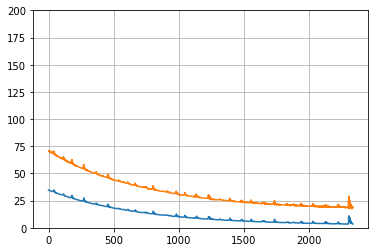

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.ylim(0, 200)

In [66]:
# Delete the training set to save some ram
'''del(lightcurve_train)
del(data_train)'''

# Demonstrate recreation
yhat = model.predict(lightcurve_test, verbose=1)
yhat_loss = model.evaluate(lightcurve_test, lightcurve_test, verbose=1)
yhat1 = model.predict(yhat, verbose=1)
print(len(yhat[4,:,1]))

1/1 [==============================] - 0s 16ms/step
117


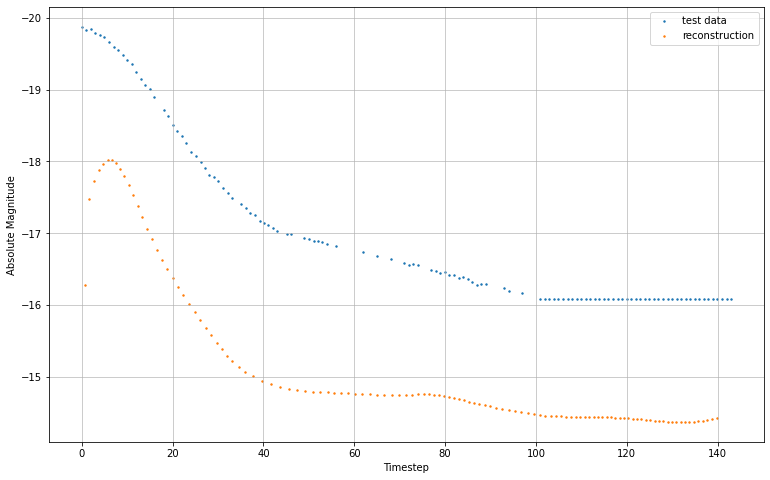

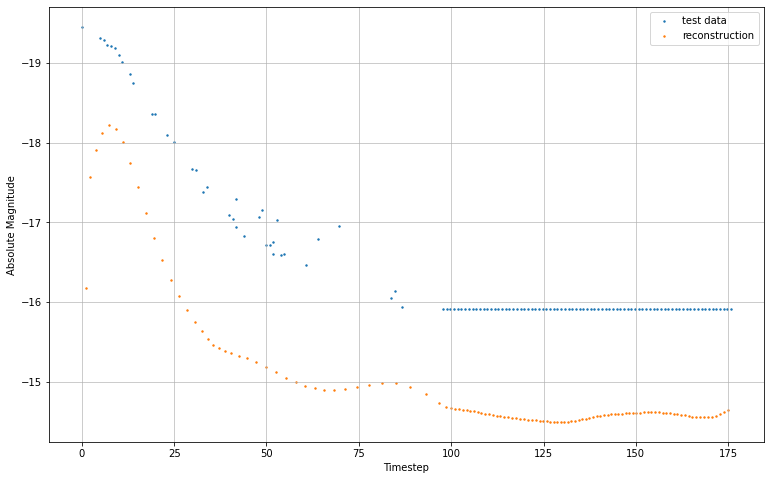

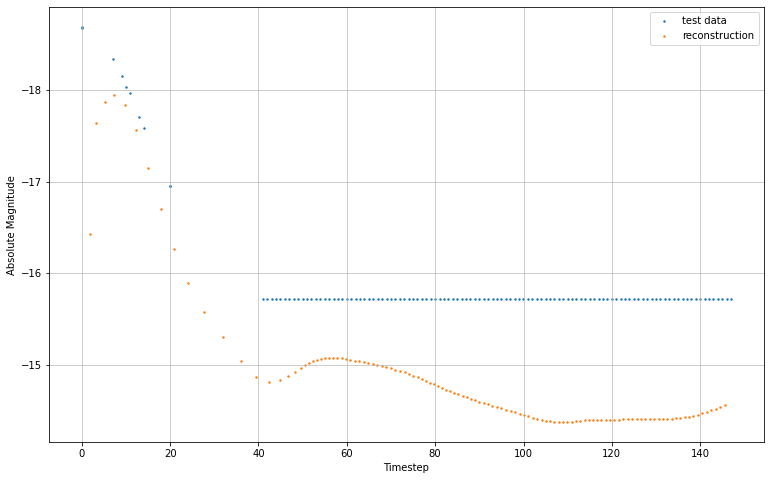

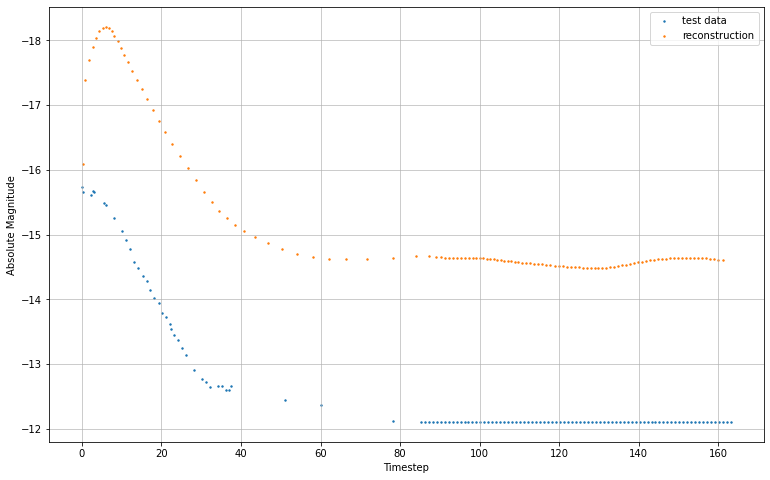

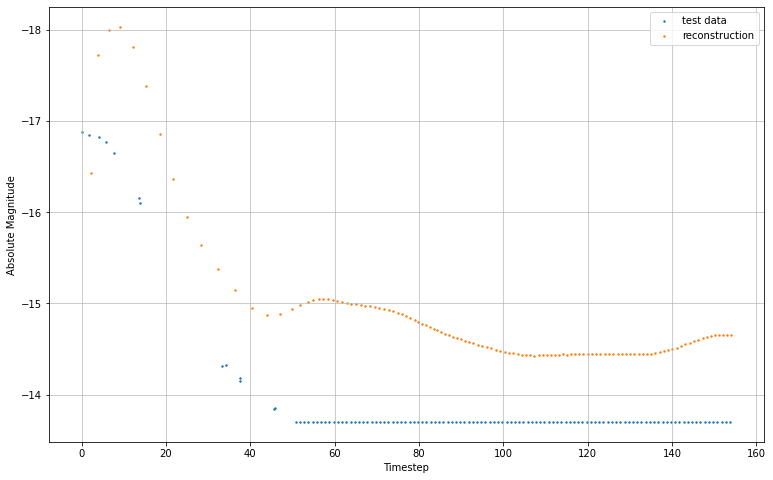

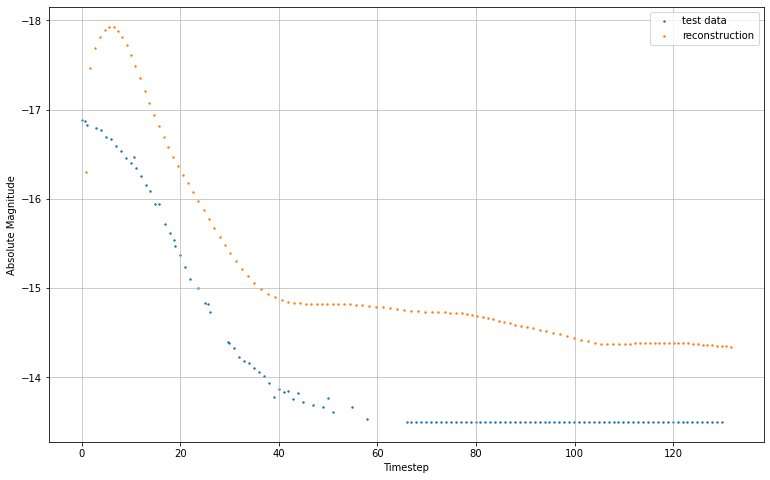

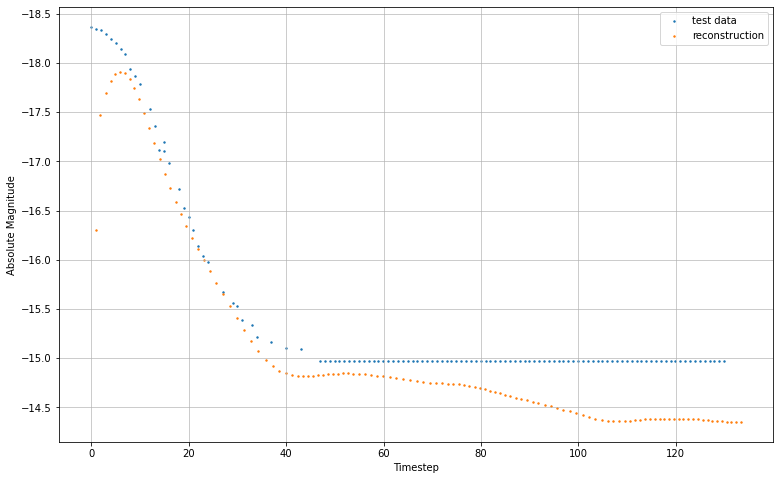

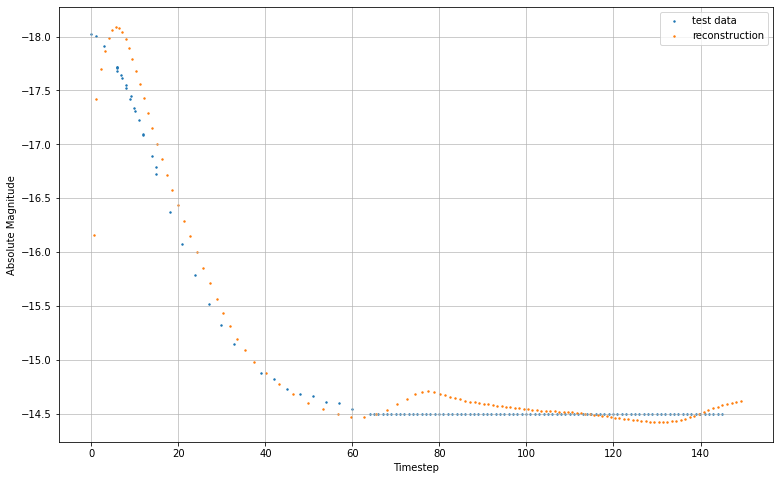

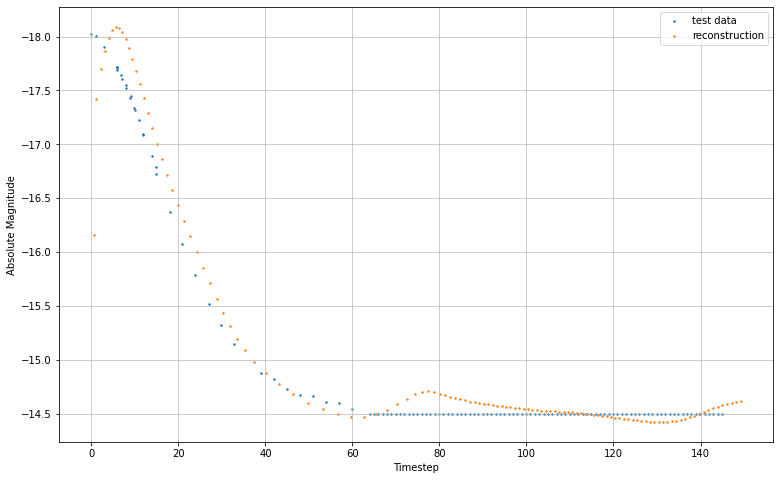

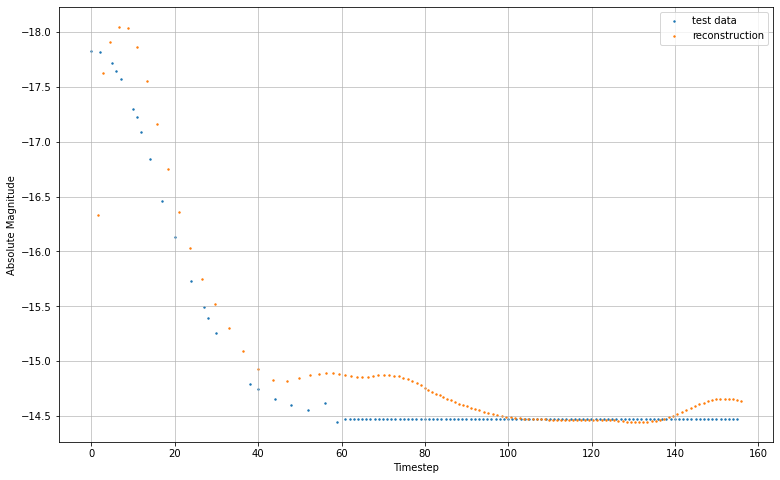

In [67]:
j = 0

for i in range(len(data_test)):
    fig = plt.figure(figsize=(12.8,8))
    ax = fig.add_subplot(1, 1, 1)

    plt.gca().invert_yaxis()

    # And a corresponding grid
    ax.grid(which='major', alpha=0.8)
    ax.grid(which='minor', alpha=0.3)

    plt.xlabel('Timestep')
    plt.ylabel('Absolute Magnitude')
    
    #plt.xlim(0, 100)

    '''x = np.linspace(1, lightcurve_length_max, lightcurve_length_max)

    plt.scatter(x, lightcurve_test[j,:,0], s=2)
    plt.scatter(x, yhat[j,:,0], s=2)'''
    
    plt.scatter(lightcurve_test[j,:,0], lightcurve_test[j,:,1], s=2, label='test data')
    plt.scatter(yhat[j,:,0], yhat[j,:,1], s=2, label='reconstruction')
    
    plt.legend()
        
    #print('the claimed type is', Type[i+split]) # This line is incorrect for now
        
    plt.show()
        
    j += 1

 
-0.1074 x - 17.64
0.011669349883432711


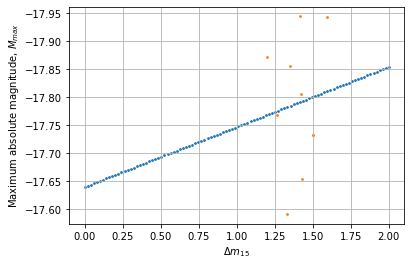

In [63]:
# Philips relation

from sklearn.metrics import r2_score

M = []
dm_P = []

fitting_days = 15

for i in range(len(data_test)): # Loop through all SN
    maximum = np.argmin(yhat[i,:,1]) # Find the id of maximum magnitude
    peak_time = yhat[i,maximum,0] # Save the day of maximum magnitude
    tail_time = yhat[i,maximum,0] # Save the day of the end of the initial lightcurve fall off
        
        # Calculate the day of the end of the initial lightcurve fall off
    j = 0
    if (peak_time + fitting_days) < yhat[i,-1,0]: # Avoid light curve that is too short (fewer than 15 days after the peak)
        while tail_time < (peak_time + fitting_days):
            tail_time = yhat[i,maximum+j,0]
            if tail_time > (peak_time + fitting_days):
                break
            j += 1
        
        # Save the peaking part of the light curve
        t = yhat[i,0:maximum+j,0]
        m = yhat[i,0:maximum+j,1]
        
        # Polynomial (degree = 3) fit of the peak part of the light curve 
        P = np.poly1d(np.polyfit(t, m, deg = 3))
        P_max = (-1*P[2] + ((P[2])**2 - 3*P[3]*P[1])**(1/2))/(3*P[3])
        
        M.append(P(P_max))
        dm_P.append(P(P_max + 15) - P(P_max))

#P1 = np.poly1d(np.polyfit(dm_P, M, deg = 1))
P1 = np.poly1d(np.polyfit(dm_P, M, deg = 1))
print(P1)
print(r2_score(M, P1(dm_P)))

# Plot out the linear relationship
plt.gca().invert_yaxis()
plt.xlabel('$\Delta m_{15}$')
plt.ylabel('Maximum absolute magnitude, $M_{max}$')
plt.grid()
x = np.linspace(0, 2, 100)
plt.scatter(x, P1(x), s=3)
plt.scatter(dm_P, M, s=3)